# basemodels will be calibrated and threshold analysis will be performed to find the optimal classification threshold on the train set

## import libraries

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    fbeta_score,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

## data loading & usual preparations

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])

# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

 -> dataframe has 7217 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns
train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


----
## functions

"calibration" is implemented into the "vary_threshold" function

In [3]:
def vary_threshold(clf, name, thresholds, calib: bool = True):
    if calib:
        clf = CalibratedClassifierCV(clf, method="isotonic")
        clf.fit(X_train, y_train)

    proba_train = clf.predict_proba(X_train)

    acc, prec, reca = [], [], []
    f1, f2, roc_auc = [], [], []

    cm_cmap = sns.light_palette("seagreen", as_cmap=True)
    nrows, ncols = 5, 7
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 13))
    plt.suptitle(name)
    ax = ax.flatten()

    for i, thresh in enumerate(thresholds):
        y_pred = (proba_train[:, 1] > thresh) * 1

        roc_auc.append(roc_auc_score(y_true=y_train, y_score=proba_train[:, 1]))
        prec.append(precision_score(y_true=y_train, y_pred=y_pred))
        reca.append(recall_score(y_true=y_train, y_pred=y_pred))
        acc.append(accuracy_score(y_true=y_train, y_pred=y_pred))
        f1.append(f1_score(y_true=y_train, y_pred=y_pred))
        f2.append(fbeta_score(y_true=y_train, y_pred=y_pred, beta=2))

        iax = ax[i]
        plt.subplot(nrows, ncols, i + 1)
        sns.heatmap(
            confusion_matrix(y_train, y_pred),
            annot=True,
            cmap=cm_cmap,
            fmt="g",
            cbar=False,
        )
        plt.title(f"thresh. = {round(thresh,2)}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        iax.set_aspect("equal", "box")

    plt.tight_layout()

    # ------------------------------------------------------------
    df2 = pd.DataFrame({"thresh": thresholds})
    df2["acc"] = acc
    df2["prec"] = prec
    df2["reca"] = reca
    df2["f1"] = f1
    df2["f2"] = f2
    df2["roc_auc"] = roc_auc

    cols = ["acc", "prec", "reca", "f1", "f2", "roc_auc"]
    _, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 30))
    for i, c in enumerate(cols):
        plt.subplot(6, 1, i + 1)
        sns.barplot(data=df2, x="thresh", y=c)
        plt.title(c)
        plt.xlabel("threshold")
        plt.ylabel(c)
        plt.ylim(df2[c].min() - 0.01, df2[c].max() + 0.01)
    plt.tight_layout()

    #
    plt.figure()
    sns.lineplot(df2.set_index("thresh", drop=True))

    return clf

In [4]:
def new_threshold(mdl, new_threshold=0.5):
    proba_train = mdl.predict_proba(X_train)
    pred_train = (proba_train[:, 1] > new_threshold) * 1

    proba_test = mdl.predict_proba(X_test)
    pred_test = (proba_test[:, 1] > new_threshold) * 1

    # evaluate model
    em.report(
        y_train=y_train,
        y_train_pred=pred_train,
        y_train_proba=proba_train,
        y_test=y_test,
        y_test_pred=pred_test,
        y_test_proba=proba_test,
    )

----
## models & parameters


In [5]:
models = [
    os.path.join("..", "models", "calibrated", "RF_calib.pickle"),
    os.path.join("..", "models", "calibrated", "XGB_calib.pickle"),
    os.path.join("..", "models", "calibrated", "SVC_calib.pickle"),
]

with open(os.path.join(models[0]), "rb") as f:
    rf_calib = pickle.load(f)
with open(os.path.join(models[1]), "rb") as f:
    xgb_calib = pickle.load(f)
with open(os.path.join(models[2]), "rb") as f:
    svc_calib = pickle.load(f)

thresholds = [i / 100 for i in list(range(16, 86, 2))]

print(thresholds)
print(len(thresholds))

[0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84]
35


----

## Voting

In [6]:
vtg_calib = VotingClassifier(
    estimators=[
        ("calibrated_xgb", xgb_calib),
        ("calibrated_rf", rf_calib),
        ("calibrated_svc", svc_calib),
    ],
    voting="soft",
)
# Fit the voting classifier with training data
vtg_calib.fit(X_train, y_train)

VotingClassifier(estimators=[('calibrated_xgb',
                              CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                                                ColumnTransformer(transformers=[('scaler',
                                                                                                                 MinMaxScaler(),
                                                                                                                 ['sp_fix_count',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sp_len_px_total',
                                                                                                                  'sp_saccade_amplitude_px_mean',
                                                                                                                  'sp_saccade_amplitude_px_var',
                                                                                                                  'sp_distance_to_centre_px_mean',
                                                                                                                  'sp_distance_to_centre_px_var...
                                                                                                                 ['sp_fix_duration_ms_total',
                                                                                                                  'sp_fix_duration_ms_mean',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sam_sal_first_fixation',
                                                                                                                  'sam_sal_sum',
                                                                                                                  'sam_sal_KLD',
                                                                                                                  'obj_t_abs_on_background',
                                                                                                                  'obj_t_abs_on_animate',
                                                                                                                  'obj_n_fix_background',
                                                                                                                  'obj_n_fix_inanimate',
                                                                                                                  'obj_n_fix_animate'])])),
                                                                               ('classifier',
                                                                                SVC(C=0.1,
                                                                                    degree=4,
                                                                                    kernel='poly',
                                                                                    probability=True))]),
                                                     method='isotonic'))],
                 voting='soft')

VotingClassifier(estimators=[('calibrated_xgb',
                              CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                                                ColumnTransformer(transformers=[('scaler',
                                                                                                                 MinMaxScaler(),
                                                                                                                 ['sp_fix_count',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sp_len_px_total',
                                                                                                                  'sp_saccade_amplitude_px_mean',
                                                                                                                  'sp_saccade_amplitude_px_var',
                                                                                                                  'sp_distance_to_centre_px_mean',
                                                                                                                  'sp_distance_to_centre_px_var...
                                                                                                                 ['sp_fix_duration_ms_total',
                                                                                                                  'sp_fix_duration_ms_mean',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sam_sal_first_fixation',
                                                                                                                  'sam_sal_sum',
                                                                                                                  'sam_sal_KLD',
                                                                                                                  'obj_t_abs_on_background',
                                                                                                                  'obj_t_abs_on_animate',
                                                                                                                  'obj_n_fix_background',
                                                                                                                  'obj_n_fix_inanimate',
                                                                                                                  'obj_n_fix_animate'])])),
                                                                               ('classifier',
                                                                                SVC(C=0.1,
                                                                                    degree=4,
                                                                                    kernel='poly',
                                                                                    probability=True))]),
                                                     method='isotonic'))],
                 voting='soft')

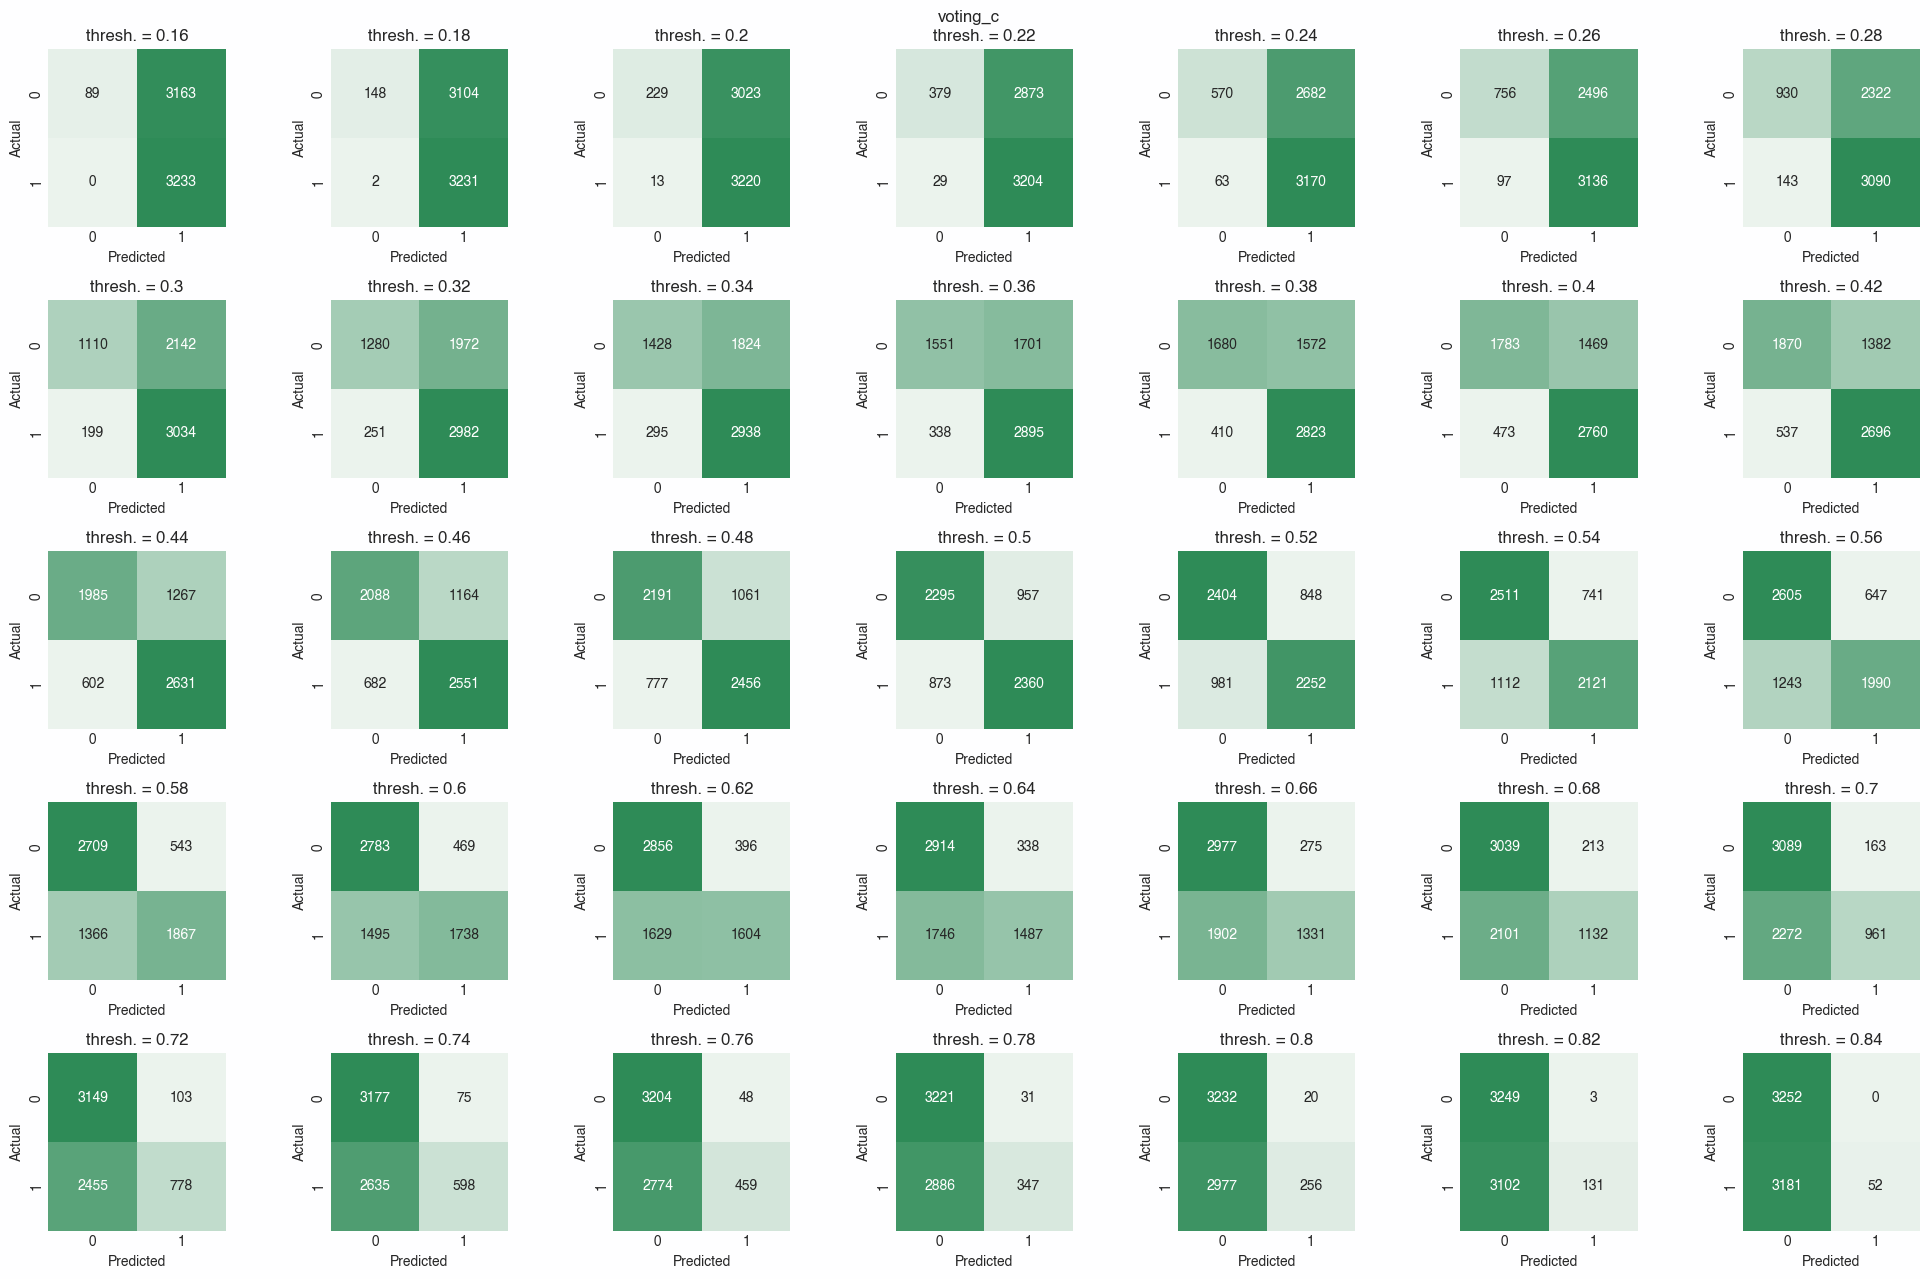

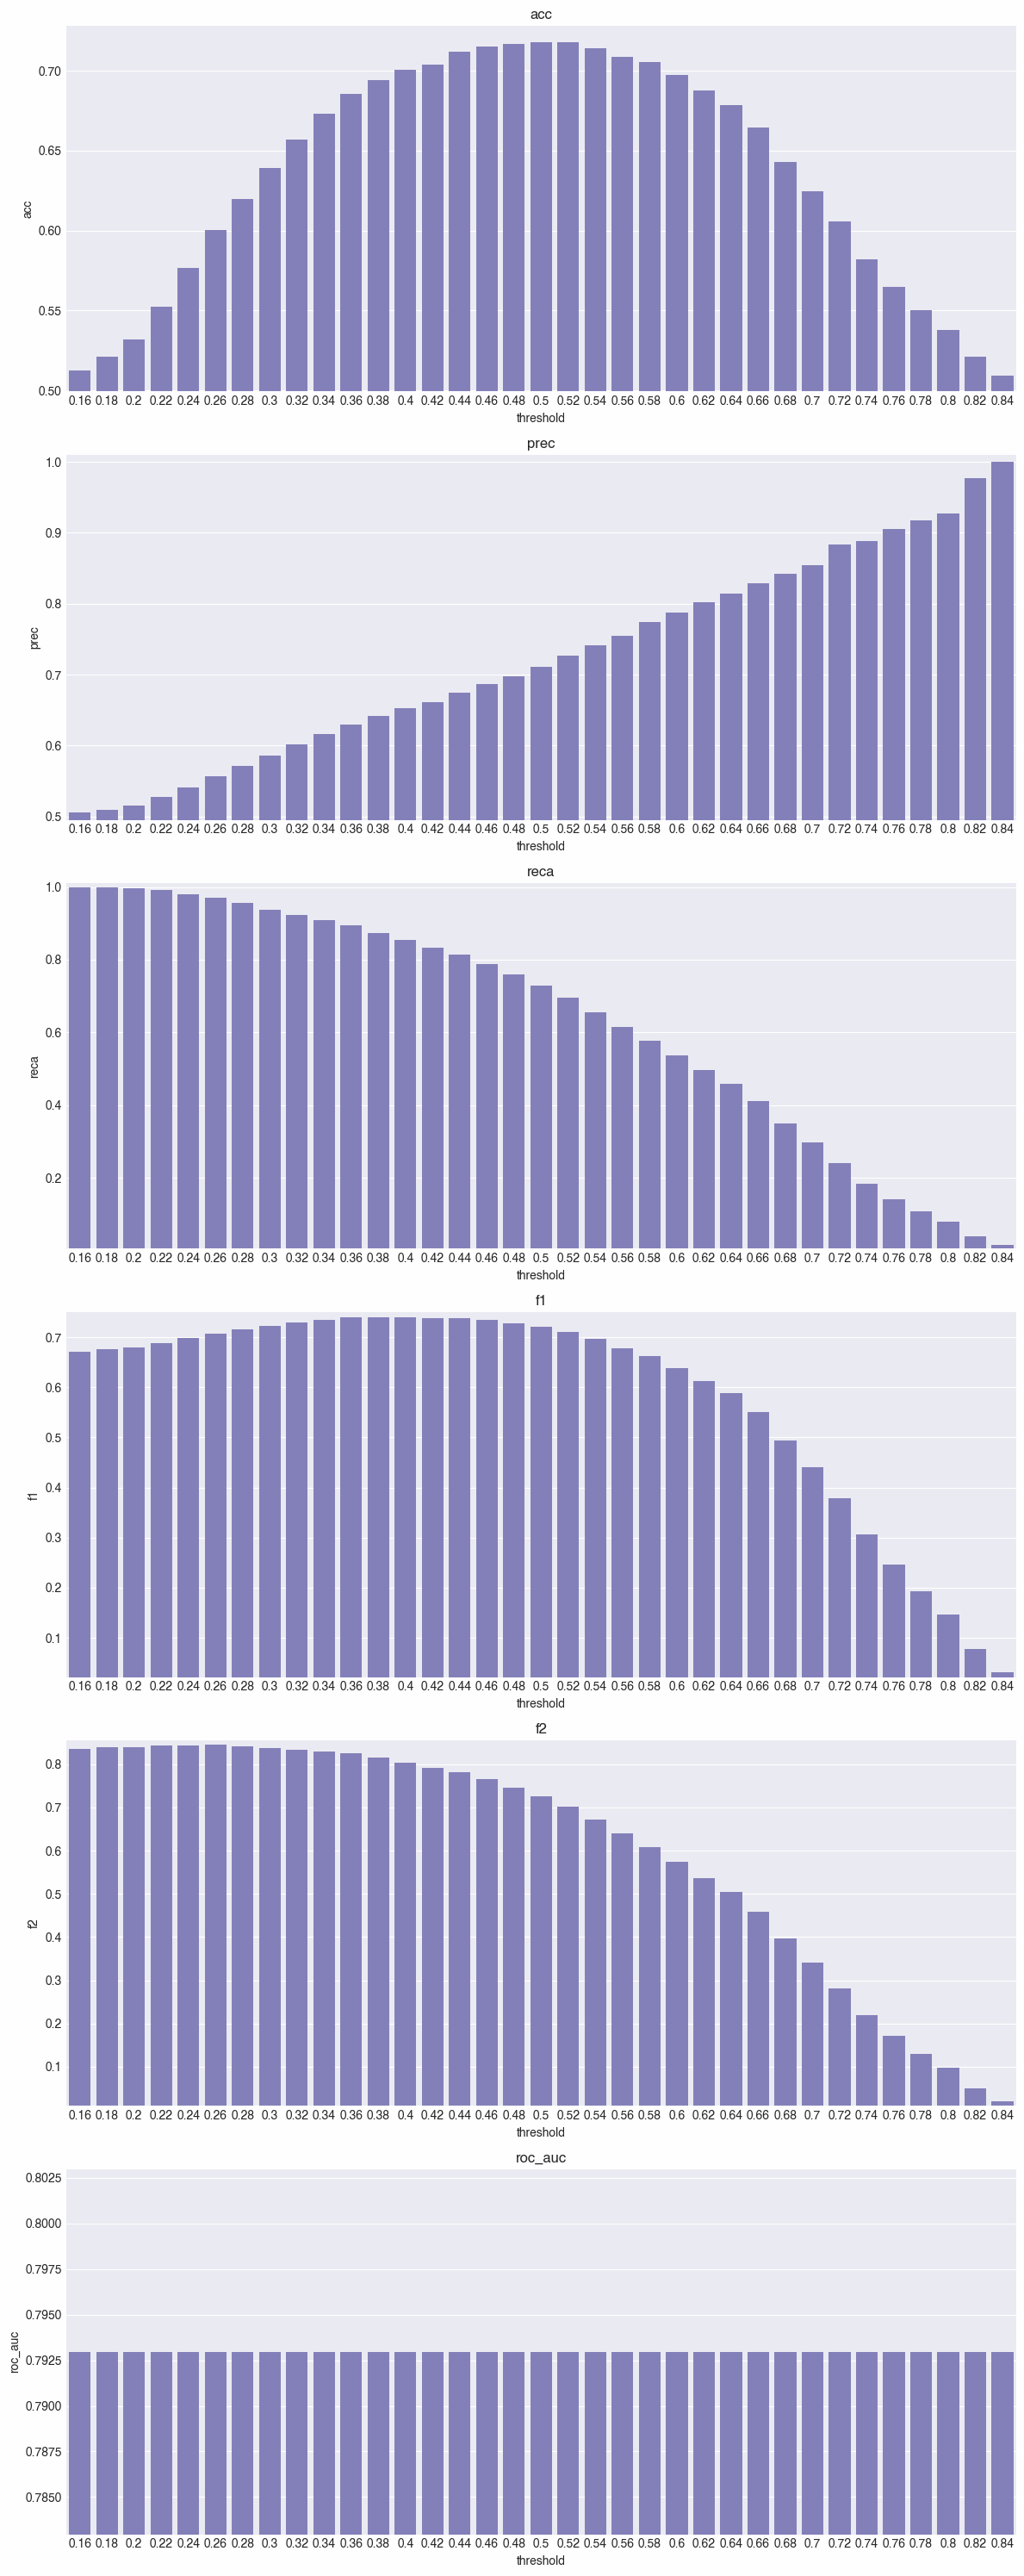

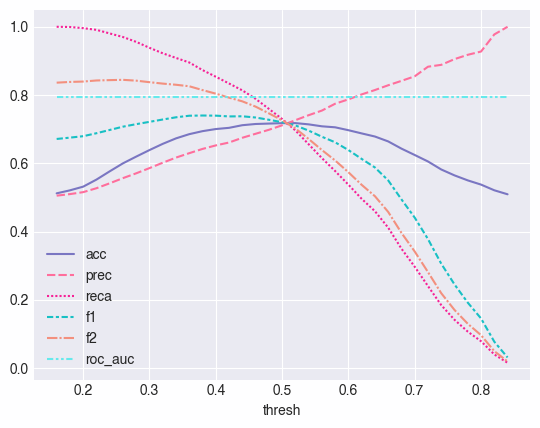

In [7]:
vary_threshold(vtg_calib, "voting_c", thresholds=thresholds, calib=False)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.790     0.548     0.647      3252
           1      0.653     0.854     0.740      3233

    accuracy                          0.701      6485
   macro avg      0.721     0.701     0.694      6485
weighted avg      0.722     0.701     0.693      6485

f(0.5)-score: 0.685
f(2.0)-score: 0.804

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.787     0.547     0.645       371
           1      0.646     0.848     0.733       361

    accuracy                          0.695       732
   macro avg      0.716     0.697     0.689       732
weighted avg      0.717     0.695     0.689       732

f(0.5)-score: 0.678
f(2.0)-score: 0.798



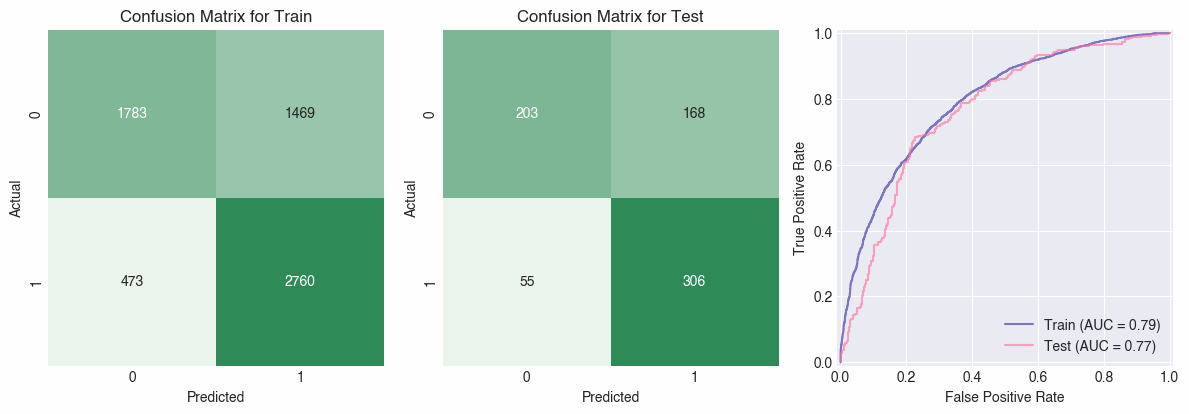

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.724     0.706     0.715      3252
           1      0.711     0.730     0.721      3233

    accuracy                          0.718      6485
   macro avg      0.718     0.718     0.718      6485
weighted avg      0.718     0.718     0.718      6485

f(0.5)-score: 0.715
f(2.0)-score: 0.726

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.711     0.749     0.730       371
           1      0.727     0.687     0.707       361

    accuracy                          0.719       732
   macro avg      0.719     0.718     0.718       732
weighted avg      0.719     0.719     0.718       732

f(0.5)-score: 0.719
f(2.0)-score: 0.695



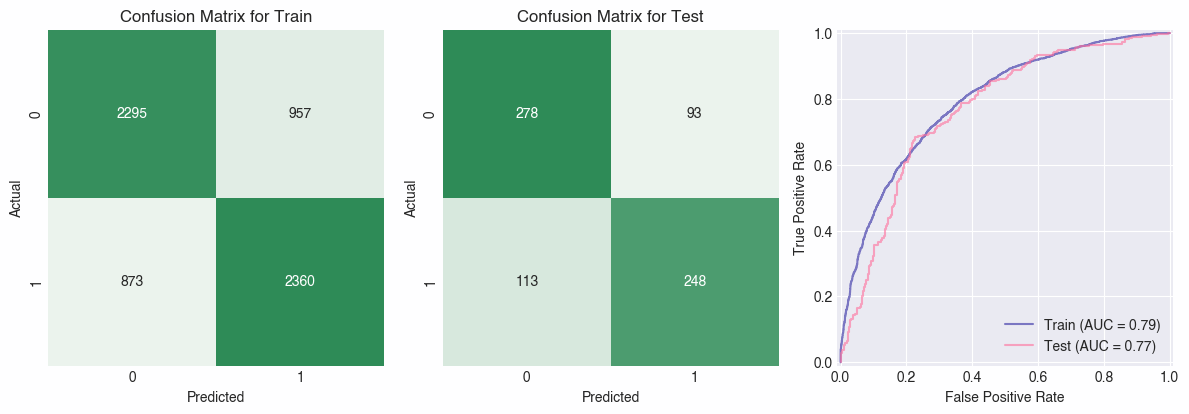

In [8]:
new_threshold(vtg_calib, new_threshold=0.4)
new_threshold(vtg_calib, new_threshold=0.5)

----

# save calibrated models

In [9]:
em.save_model(
    m=vtg_calib,
    file="VTG_calib.pickle",
    folder=os.path.join("..", "models", "calibrated"),
)

 -> model saved in: '../models/calibrated/VTG_calib.pickle'
